# Research Space

The primary aim of this experiment is to construct a visual representation delineating the temporal evolution of the research landscape within Tübingen. This visualization encompasses the dynamic interplay between academic faculty (professors) and the associated spectrum of research fields over time.


In [1]:
import os
import ast
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
from tueplots import bundles
import matplotlib.pyplot as plt
from IPython.display import Image
from tueplots.constants.color import rgb

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 300, 'font.family': 'Times New Roman'})

In [2]:
df = pd.read_csv("./../dat/ProjectedPublications.csv")
unique_df = df.drop_duplicates(subset='Title', keep='first')

years = range(df['Year'].min(), df['Year'].max() + 1)
professors = df["Professor"].unique()

research_fields = [
    'Computer Vision',
    'Robotics',
    'Bioinformatics and Computational Biology',
    'Human-Computer Interaction',
    'Design Automation of Microelectronic Systems (EDA)',
    'Visualization', 
    'Web Information Retrieval',
    'Natural Language Processing',
    'Machine Learning', 
]

sorted_research_fields = ["Machine Learning", "Computer Vision", "Robotics", "Bioinformatics and Computational Biology", "Human-Computer Interaction", "Visualization", "Design Automation of Microelectronic Systems (EDA)", "Web Information Retrieval", "Natural Language Processing"]
sorted_colors = [rgb.tue_darkgreen, rgb.pn_orange, rgb.tue_darkblue, rgb.tue_lightblue, rgb.tue_brown, rgb.tue_blue, rgb.tue_green, rgb.tue_dark, rgb.tue_red]
colors = dict(zip(sorted_research_fields, sorted_colors))

def format_name(name):
    parts = name.split()
    formatted_name = parts[0][0].upper() + ". " + parts[-1]
    return formatted_name

In [3]:
for year in tqdm(years, desc="Creating Plot for Each Year"):
    year_df = df[df['Year'] <= year]
    unique_year_df = unique_df[unique_df['Year'] <= year]

    fig, ax = plt.subplots()
    fig.set_size_inches(fig.get_size_inches()[0], fig.get_size_inches()[0])

    # Papers
    paper_colors = unique_year_df['Research Field'].apply(lambda x: colors[x]).tolist()
    ax.scatter(unique_year_df['x'], unique_year_df['y'], color=paper_colors, alpha=0.1, s=10, zorder=1)

    # Professors
    for professor in professors:
        professor_df = year_df[year_df['Professor'] == professor]
        if len(professor_df) != 0:
            professor_x, professor_y = professor_df[['x', 'y']].mean()
            ax.scatter(professor_x, professor_y, color=rgb.tue_dark, alpha=0.7, s=8, zorder=2)
            y, va = 0.3, 'bottom'
            if professor == 'Philipp Berens':
                y, va = -y, 'top'
            ax.text(professor_x, professor_y + y, format_name(professor), ha='center', va=va, fontsize=5.5, zorder=4)

    # Research Fields
    legend = False
    for research_field in research_fields:
        research_field_df = unique_year_df[unique_year_df["Research Field"] == research_field]
        if len(research_field_df) > 1:
            legend = True
            research_field_df = research_field_df[['x', 'y']].to_numpy()
            research_field_df = research_field_df[np.argsort(np.linalg.norm(research_field_df - research_field_df.mean(axis=0), axis=1))[:int(0.90 * len(research_field_df))]]
            research_field_mean = research_field_df.mean(axis=0)
            research_field_radius = np.mean(np.linalg.norm(research_field_df - research_field_mean, axis=1))
            ax.add_patch(plt.Circle(research_field_mean, research_field_radius, color=(*colors[research_field], 0.5), linewidth=2, fill=False, zorder=1, label=research_field))
    
    ax.set_xlim([-80, 80])
    ax.set_ylim([-80, 80])

    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    
    ax.set_title(f'Research Space (Until Year {year})')

    if legend:
        ax.legend(title="Research Fields", loc="lower right", framealpha=1, facecolor="white", frameon=True, fontsize='x-small')

    plt.close()

    fig.savefig(f'./../plt/ResearchSpace/{year}.png')

Creating Plot for Each Year: 100%|█████████████████████████████████████████████████████| 35/35 [00:38<00:00,  1.11s/it]


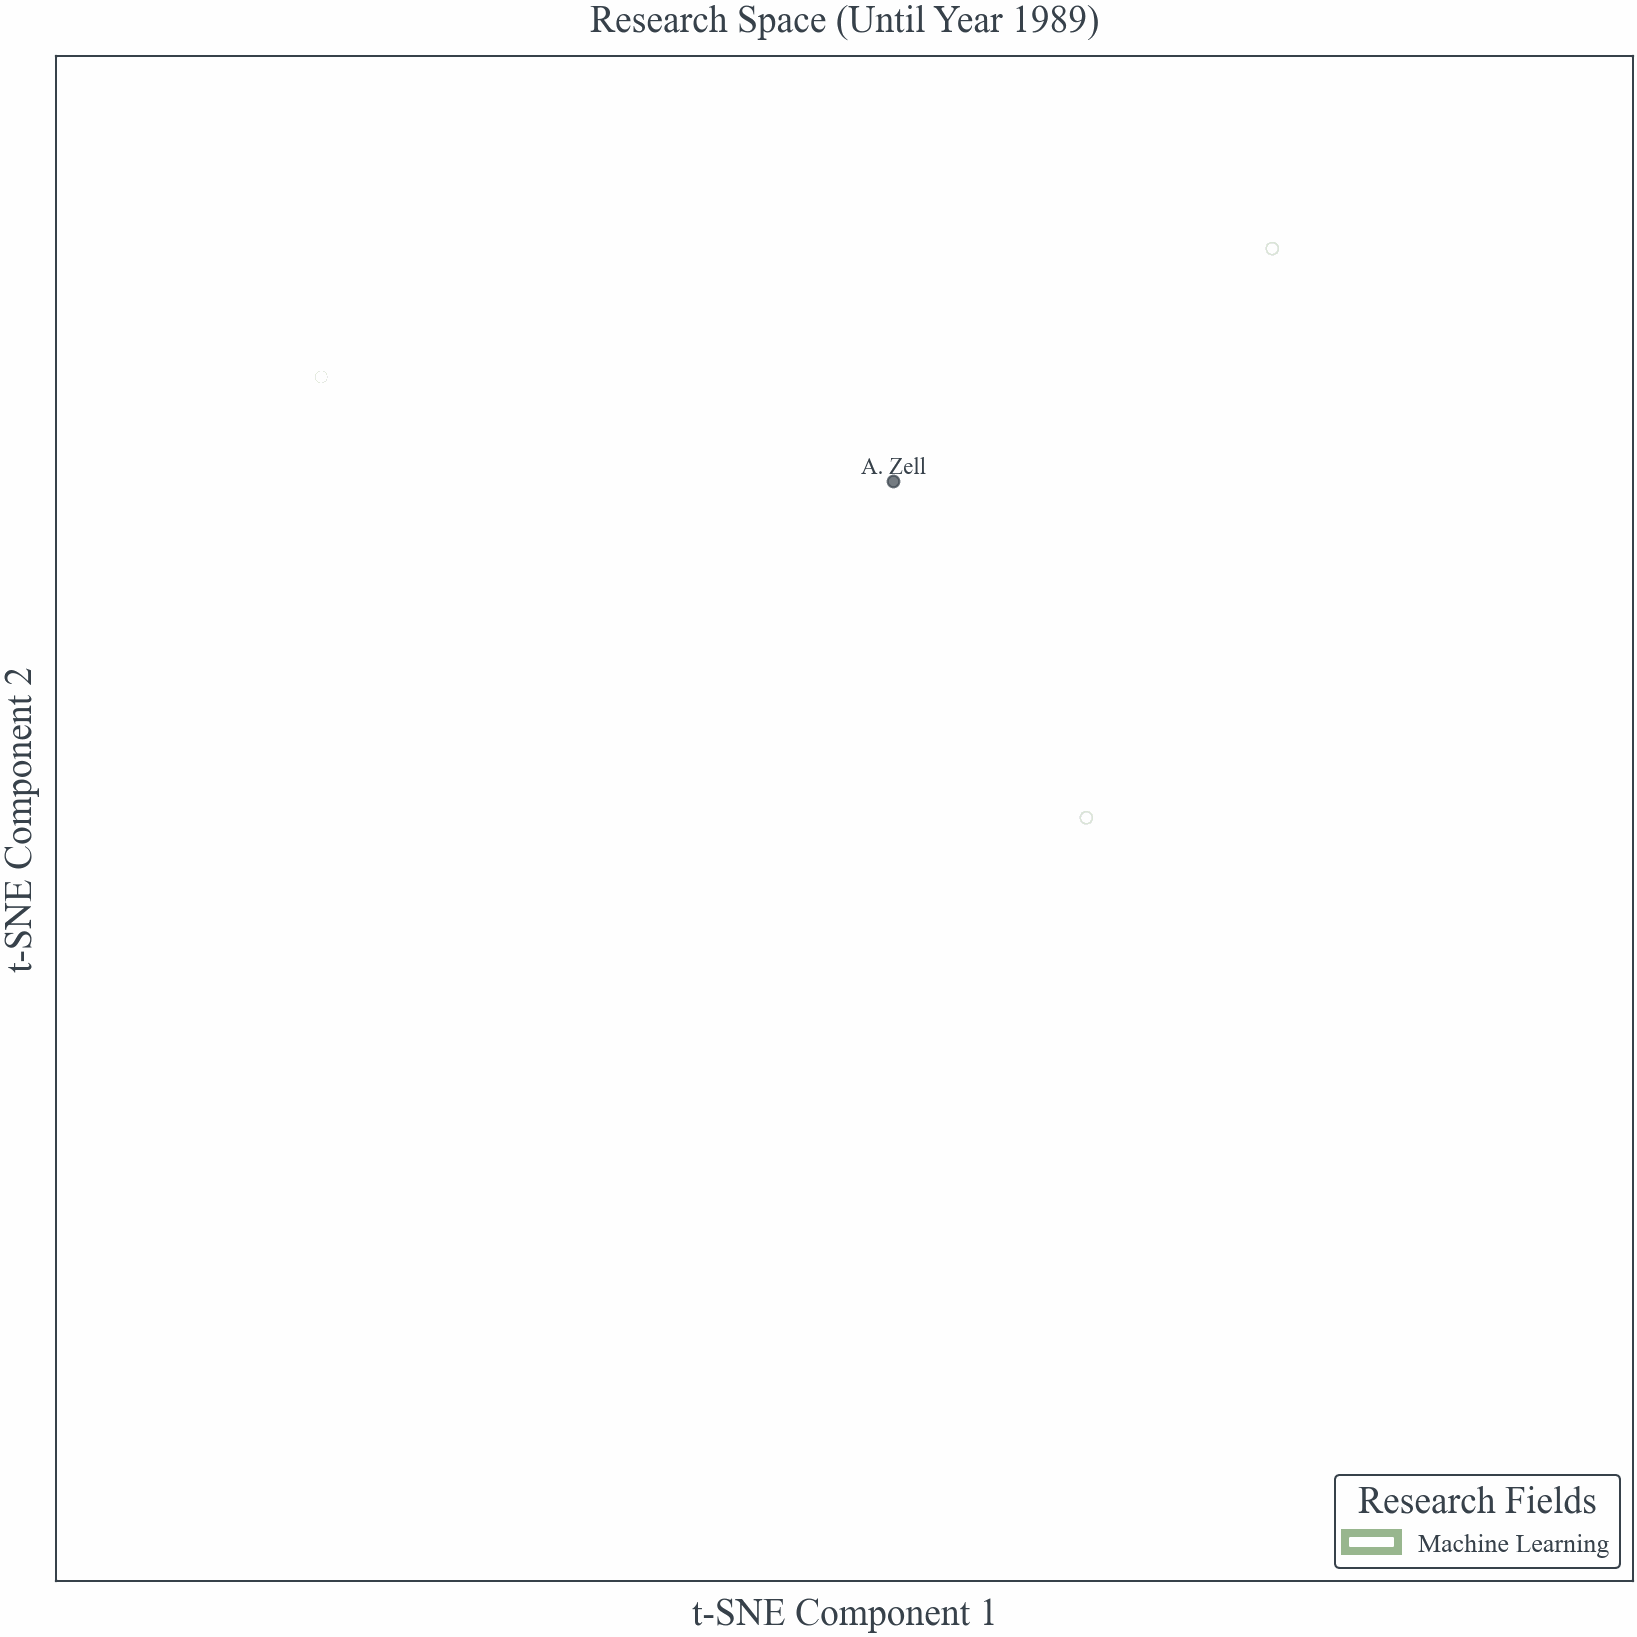

In [4]:
# Create a gif combining plots of all years
png_dir = './../plt/ResearchSpace/'
png_files = [f for f in os.listdir(png_dir) if f.endswith('.png')]

frames = []
for png_file in png_files:
    frames.append(imageio.v2.imread(os.path.join(png_dir, png_file)))

imageio.mimsave('./../plt/ResearchSpace/ResearchSpace.gif', frames, fps=1, loop=0)

Image(filename='./../plt/ResearchSpace/ResearchSpace.gif')